In [1]:
##https://www.zhihu.com/question/596950521/answer/3109759716
# 导入常用模块
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader



# 配置参数
from argparse import Namespace
cfg = Namespace()

#dataset
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column = None
cfg.source_prefix = '' #添加到每个prompt开头的前缀引导语

cfg.max_source_length = 128
cfg.max_target_length = 128

#model
cfg.model_name_or_path = 'chatglm2-6b-Aha-GPT'  #远程'THUDM/chatglm-6b'
#cfg.model_name_or_path = 'chatglm2-6b'  #远程'THUDM/chatglm-6b'
cfg.quantization_bit = None #仅仅预测时可以选 4 or 8


#train
cfg.epochs = 100
cfg.lr = 5e-3
cfg.batch_size = 1
cfg.gradient_accumulation_steps = 16 #梯度累积

###

import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, DataCollatorForSeq2Seq

config = AutoConfig.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)

model = AutoModel.from_pretrained(cfg.model_name_or_path, config=config,
                                  trust_remote_code=True).half()

# 先量化瘦身
if cfg.quantization_bit is not None:
    print(f"Quantized to {cfg.quantization_bit} bit")
    model = model.quantize(cfg.quantization_bit)

# 再移动到GPU上
model = model.cuda()

# 通过注册jupyter魔法命令可以很方便地在jupyter中测试ChatGLM
from torchkeras.chat import ChatGLM

chatglm = ChatGLM(model, tokenizer)

Hello, 我是由啊蛤开发的Aha-GPT，快来一起玩耍叭！


In [2]:
%%chatglm
什么是Modified Nearest Neighbor?

Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前解$X_i$，其改进的最邻近解$X_i^*$必须满足以下两个条件（当应对最小化问题）：
(1)构建一个集合$S_i$ = {$X| X \in P(t) \cap f(X) < f(X_i)$}；
(2)如果$S_i \ne \varnothing$，则 $\exists X_i^* \in S_i$，$dist(X_i^*,


In [3]:
%%chatglm
这有什么用？

Modified Nearest Neighbor (MNN) 算法可以用于解决一些最优化问题中的最小化问题，如最小生成树、最小费用最大流等问题。

在最小生成树问题中，我们希望找到一个包含 $n$ 个顶点 $P$ 的最短路径问题。对于任意一个顶点 $V$ 和它的邻居 $W \in P$，我们需要找到一个非空集合 $S_V$，使得 $V \in S_V$。然后我们需要在 $S_V$ 中寻找一个非空集合 $S_V^*$，使得 $V \in S_V^*$ 且 $dist(V, P) \le dist(V, S_V^*)$。最后，我们需要在 $S_V$ 中寻找一个最优的 $X_i^*$，使得 $dist(X_i^*, V) \le dist(X_i^*, S_V^*)$。

MNN 算法可以用于解决上述问题，它可以通过构建一个改进的最邻近解 $X_i^*$，使得问题可以转化为寻找一个最优的 $X_i^*$，使得问题转化为最小费用最大流问题。

在最小费用最大流问题中，我们希望找到一条从源点到汇点的最短路径，同时满足费用的限制。对于任意一个节点 $V$ 和一条从 $V$ 到 $W$ 的路径 $P$，我们需要找到一个非空集合 $F_V$，使得 $F_V \subseteq F_V$。然后我们需要在 $F_V$ 中寻找一个最优的 $X_i^*$，使得 $dist(X_i^*, V) \le \min(F_V)$。

MNN 算法可以用于解决上述问题，它可以通过构建一个改进的最邻近解 $X_i^*$，使得问题转化为寻找一个最优的 $X_i^*$，使得问题转化为最小费用最大流问题。


In [3]:
#定义一条知识样本~

keyword = 'Modified Nearest Neighbor (MNN)'
keyword1 = 'Aha-GPT'


description = '''Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前解$X_i$，其改进的最邻近解$X_i^*$必须满足以下两个条件（当应对最小化问题）：
(1)构建一个集合$S_i$ = {$X| X \in P(t) \cap f(X) < f(X_i)$}；
(2)如果$S_i \\ne \\varnothing$，则 $\exists X_i^* \in S_i$，$dist(X_i^*, X_i) \leq dist(X, X_i)$；'''

description1 = '''Hello, 我是由啊蛤开发的Aha-GPT，快来一起玩耍叭！'''

#对prompt使用一些简单的数据增强的方法，以便更好地收敛。
def get_prompt_list(keyword):
    return [f'{keyword}',
            f'你知道{keyword}吗?',
            f'{keyword}是什么？',
            f'介绍一下{keyword}',
            f'你听过{keyword}吗?',
            f'啥是{keyword}？',
            f'{keyword}是何物？',
            f'何为{keyword}？',
           ]

data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword)]
data1 =[{'prompt':x,'response':description1} for x in get_prompt_list(keyword1) ]
data2 = [{'prompt':'你好','response':'Hello, 我是由啊蛤开发的Aha-GPT，快来一起玩耍叭！'}]

dfdata = pd.DataFrame(data)
dfdata1 = pd.DataFrame(data1)
dfdata2 = pd.DataFrame(data2)

dfdata = pd.concat([dfdata, dfdata1])
dfdata = pd.concat([dfdata, dfdata2])
display(dfdata) 

import datasets 
#训练集和验证集一样
ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)

,prompt,response
0,Modified Nearest Neighbor (MNN),Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前...
1,你知道Modified Nearest Neighbor (MNN)吗?,Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前...
2,Modified Nearest Neighbor (MNN)是什么？,Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前...
3,介绍一下Modified Nearest Neighbor (MNN),Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前...
4,你听过Modified Nearest Neighbor (MNN)吗?,Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前...
5,啥是Modified Nearest Neighbor (MNN)？,Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前...
6,Modified Nearest Neighbor (MNN)是何物？,Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前...
7,何为Modified Nearest Neighbor (MNN)？,Modified Nearest Neighbor (MNN)：对于种群$P(t)$中的当前...
0,Aha-GPT,"Hello, 我是由啊蛤开发的Aha-GPT，快来一起玩耍叭！"
1,你知道Aha-GPT吗?,"Hello, 我是由啊蛤开发的Aha-GPT，快来一起玩耍叭！"


In [4]:
## 2，数据转换

#这是支持 history列处理，并且按照batch预处理数据的方法。

def preprocess(examples):
    max_seq_length = cfg.max_source_length + cfg.max_target_length
    model_inputs = {
        "input_ids": [],
        "labels": [],
    }
    for i in range(len(examples[cfg.prompt_column])):
        if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
            query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]

            history = examples[cfg.history_column][i] if cfg.history_column is not None else None
            prompt = tokenizer.build_prompt(query, history)

            prompt = cfg.source_prefix + prompt
            a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                     max_length=cfg.max_source_length)
            b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                     max_length=cfg.max_target_length)

            context_length = len(a_ids)
            input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
            labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]

            pad_len = max_seq_length - len(input_ids)
            input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
            labels = labels + [tokenizer.pad_token_id] * pad_len
            labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
            model_inputs["input_ids"].append(input_ids)
            model_inputs["labels"].append(labels)
    return model_inputs


ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
)

ds_val = ds_val_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_val_raw.column_names
)

Map (num_proc=4):   0%|          | 0/17 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/17 [00:00<?, ? examples/s]

In [5]:
## 3，构建管道
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=False
)

dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )


for batch in dl_train:
    break

print(len(dl_train))

17


二，定义模型下面我们使用AdaLoRA方法来微调ChatGLM2，以便给模型注入和梦中情炉 torchkeras相关的知识。AdaLoRA是LoRA方法的一种升级版本，使用方法与LoRA基本一样。主要差异在于，在LoRA中不同训练参数矩阵的秩是一样的被固定的。但AdaLoRA中不同训练参数矩阵的秩是会在一定范围内自适应调整的，那些更重要的训练参数矩阵会分配到更高的秩。通常认为，AdaLoRA的效果会好于LoRA。


In [6]:
from peft import get_peft_model, AdaLoraConfig, TaskType

#训练时节约GPU占用
model.config.use_cache=False
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    target_modules=["query", "value"]
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()

trainable params: 2924880 || all params: 6246508908 || trainable%: 0.04682423483386154


<<<<<< ⚡️ cuda is used >>>>>>


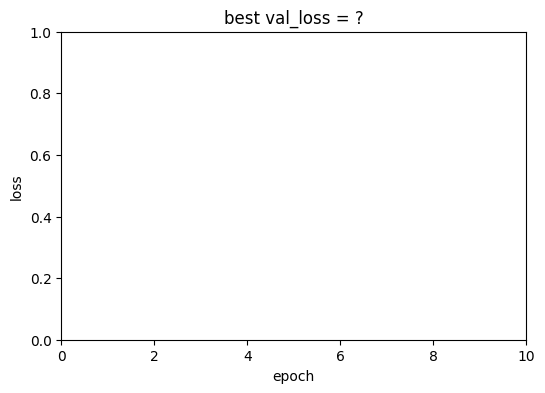

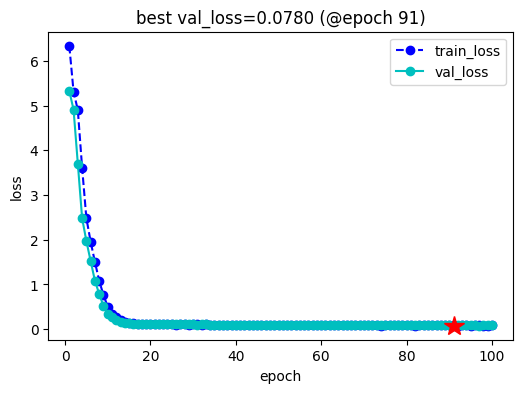

,epoch,train_loss,lr,val_loss
0,1,6.339384,0.005,5.326746
1,2,5.313074,0.005,4.910731
2,3,4.899242,0.005,3.700138
3,4,3.612822,0.005,2.485639
4,5,2.482939,0.005,1.969669
...,...,...,...,...
95,96,0.081645,0.005,0.086243
96,97,0.083397,0.005,0.079590
97,98,0.076892,0.005,0.082918
98,99,0.080390,0.005,0.083500


In [7]:


from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora相关的可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    self.net = self.net.from_pretrained(self.net.base_model.model,ckpt_path)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 



optimizer = torch.optim.AdamW(peft_model.parameters(),lr=cfg.lr) 
keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer) 
ckpt_path = 'single_chatglm2'

keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,
                patience=20,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16',
                gradient_accumulation_steps = cfg.gradient_accumulation_steps
               )

三，训练模型我们使用我们的梦中情炉torchkeras来实现最优雅的训练循环~注意这里，为了更加高效地保存和加载参数，我们覆盖了KerasModel中的load_ckpt和save_ckpt方法，仅仅保存和加载可训练lora权重，这样可以避免加载和保存全部模型权重造成的存储问题。


In [13]:
from peft import PeftModel 
ckpt_path = 'single_chatglm2'
model_old = AutoModel.from_pretrained("chatglm2-6b",
                                  load_in_8bit=False, 
                                  trust_remote_code=True)
peft_loaded = PeftModel.from_pretrained(model_old,ckpt_path).cuda()
model_new = peft_loaded.merge_and_unload() #合并lora权重


chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=20) #支持多轮对话，可以从之前对话上下文提取知识。

save_path = "chatglm2-6b-Aha-GPT"
model_new.save_pretrained(save_path, max_shard_size='2GB')


tokenizer.save_pretrained(save_path)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 508.00 MiB (GPU 0; 23.70 GiB total capacity; 22.85 GiB already allocated; 202.31 MiB free; 22.91 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
%%chatglm
你听说过Modified Nearest Neighbor吗？

Modified Nearest Neighbor (MNN)是一种用于分类问题的新型神经网络算法。与传统的Nearest Neighbor (NN)算法不同,MNN对特征空间进行修改,通过在特征空间中加入一个惩罚项来避免过拟合。

MNN在很多领域都表现出色,例如图像分类、语音识别、自然语言处理等。MNN的特点是能够有效地处理数据中的噪声和异常值,同时对数据中的模式具有较好的鲁棒性。

由于MNN具有很好的可扩展性,可以很容易地应用于大规模数据集分类任务中。此外,MNN也比较高效,可以在训练和推理阶段使用不同的实现方式。
